## Code for the initial analysis of Habitats within the UK

In [8]:
import os
import pandas as pd
import osgeo as ogr
import numpy as np
import rasterio
import geopandas as gpd
import pyproj
import jinja2
from pyproj import CRS
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.warp import transform_geom, calculate_default_transform, reproject
import osgeo.ogr
import shapely.wkt
import matplotlib.pyplot as plt
from shapely.geometry import box
from shapely.geometry import mapping
import nbconvert
import jinja2

In [34]:
# Define the base data path
base_path = "C:\\Users\\bp424\\OneDrive - University of Exeter\\University\\PhD\\Term1\\Term1_Assessment\\Data"

# Change the current working directory
os.chdir(base_path)

# Construct paths and download Sentinel-2 imagery 
S2_2021_path = os.path.join(base_path, "Sentinel2", "S2_2021_full.tif")
S2_2021 = rasterio.open(S2_2021_path)

S2_2023_path = os.path.join(base_path, "Sentinel2", "S2_2023.tif")
S2_2023 = rasterio.open(S2_2023_path)

# Open geopackages of UKCEH Land Cover Map
HS2_boundary = gpd.read_file(os.path.join(base_path, "HS2_location", "HS2_area_BNG.shp"))
LCM = gpd.read_file(os.path.join(base_path, "UKCEH", "UKCEH_HS2", "lcm-2021-vec", "lcm-2021-vec_5316125.gpkg"))

In [35]:
#Check they are in the same CRS
print("Sentienl_2 2021 CRS:", S2_2021.crs)
print("Sentienl_2 2023 CRS:", S2_2023.crs)
print("LCM CRS:", LCM.crs)

Sentienl_2 2021 CRS: EPSG:27700
Sentienl_2 2023 CRS: EPSG:27700
LCM CRS: epsg:27700


In [36]:
#Clip the LCM to the extent of the S2 Boundary 
clipped_LCM = gpd.clip(LCM, HS2_boundary)

# Specify the output path for the clipped LCM GeoPackage
output_path_clipped_lcm = os.path.join(base_path, "UKCEH", "UKCEH_HS2", "clipped_LCM.gpkg")

# Save the clipped LCM GeoDataFrame to GeoPackage
clipped_LCM.to_file(output_path_clipped_lcm, driver="GPKG")

C:\Users\bp424\AppData\Local\anaconda3\envs\pyGIS\lib\site-packages\geopandas\tools\clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


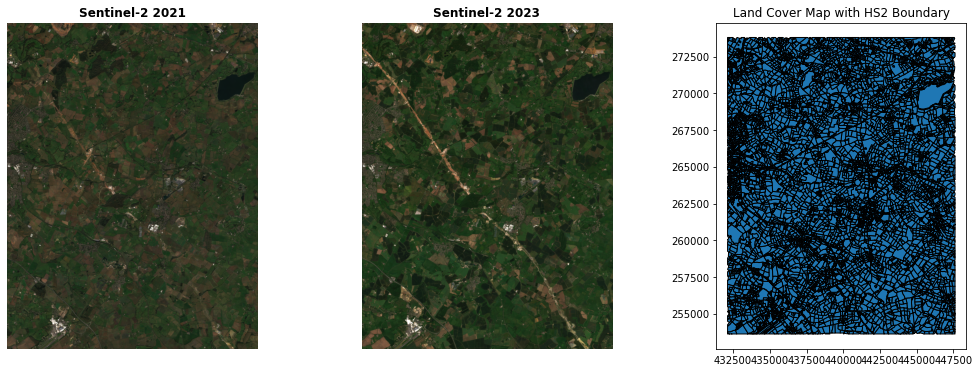

In [37]:
# Plot the Sentinel-2 imagery side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot S2_2021 (normalize to the valid range [0, 1])
rasterio.plot.show(S2_2021.read([4, 3, 2]) / 3000.0, ax=axes[0], title='Sentinel-2 2021')
axes[0].set_axis_off()

# Plot S2_2023 (normalize to the valid range [0, 1])
rasterio.plot.show(S2_2023.read([4, 3, 2]) / 3000.0, ax=axes[1], title='Sentinel-2 2023')
axes[1].set_axis_off()

# Plot the Land Cover Map
clipped_LCM.plot(ax=axes[2], edgecolor='k', legend=True)

# Set plot title
axes[2].set_title('Land Cover Map with HS2 Boundary')

# Display the plot
plt.show()


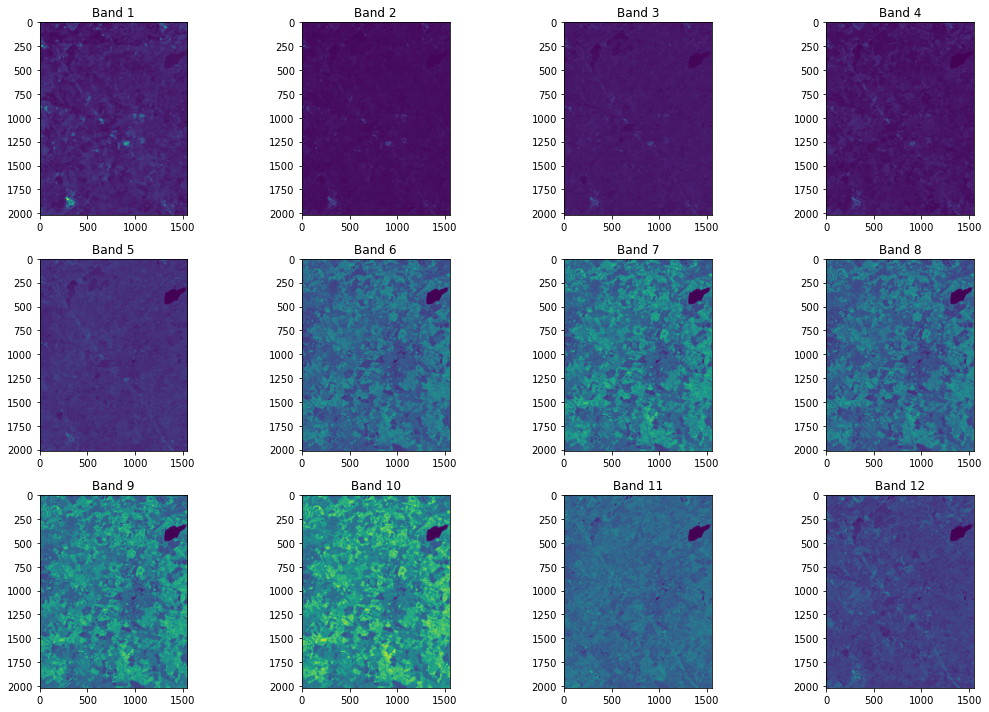

In [38]:
#visualise the first 12 bands within the S2_2021 dataset 
S2_2021 = rasterio.open(S2_2021_path, 'r+')

# Read all bands and visualise 
all_bands = S2_2021.read()

# Close the raster file
S2_2021.close()

# Plot each band
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(all_bands[i], cmap='viridis')  # You can change the colormap if needed
    ax.set_title(f'Band {i+1}')

plt.tight_layout()
plt.show()

In [39]:
#scale the S2_2021 and the S2_2023 dataset 
S2_2021 = rasterio.open(S2_2021_path, 'r+')

# Loop through each band
for band in range(1, S2_2021.count + 1):
    # Read the band data
    band_data = S2_2021.read(band)

    # Divide the band data by 10000
    scaled_band_data = np.true_divide(band_data, 10000)

    # Write the updated data back to the raster
    S2_2021.write_band(band, scaled_band_data)

# Close the raster file
S2_2021.close()

S2_2023 = rasterio.open(S2_2023_path, 'r+')
# Loop through each band
for band in range(1, S2_2023.count + 1):
    # Read the band data
    band_data = S2_2023.read(band)

    # Divide the band data by 10000
    scaled_band_data = np.true_divide(band_data, 10000)

    # Write the updated data back to the raster
    S2_2023.write_band(band, scaled_band_data)

# Close the raster file
S2_2023.close()


In [41]:
# Open the original 2021 raster file and calculate vegetation indices 
with rasterio.open(S2_2021_path) as src:
    
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Read the original bands
    blue = src.read(2)  # Blue band (B2)
    red = src.read(4)  # Red band (B4)
    nir = src.read(8)  # NIR band (B8)
    swir = src.read(11) #SWIR Band (B11)

    # Calculate Spectral Indices
    ndvi = (nir - red) / (nir + red)
    evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
    savi = (1 + 0.5) * (nir - red) / (nir + red + 0.5)
    ndbi = (swir - nir) / (swir + nir)
    mndwi = (blue - swir) / (blue + swir)

    # Create a new raster file with original bands plus spectral indices
    profile = src.profile
    profile.update(count=src.count + 6, dtype='float32')

    # Specify the output path for the new raster file
    output_path =  os.path.join(base_path, "Sentinel2", "S2_2021_w_indices.tif")

    with rasterio.open(output_path, 'w', **profile) as dst:
        # Write original bands to the new raster file
        for i in range(1, src.count + 1):
            dst.write(src.read(i), i)

        # Write spectral indices as additional bands with custom names
        dst.write(ndvi, src.count + 1)
        dst.write(evi, src.count + 2)
        dst.write(ndwi, src.count + 3)
        dst.write(savi, src.count + 4)
        dst.write(ndbi, src.count + 5)
        dst.write(mndwi, src.count + 6)

        # Set band descriptions for the new bands
        dst.set_band_description(src.count + 1, 'ndvi')
        dst.set_band_description(src.count + 3, 'ndwi')
        dst.set_band_description(src.count + 4, 'savi')
        dst.set_band_description(src.count + 5, 'ndbi')
        dst.set_band_description(src.count + 6, 'mndwi')


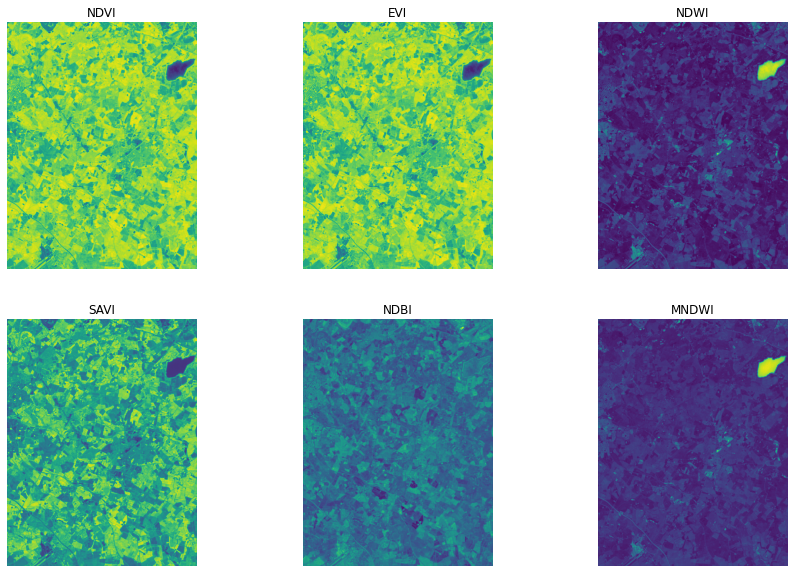

In [42]:
# Open the raster file with spectral indices
with rasterio.open(output_path) as src:
    
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Read the spectral indices
    ndvi = src.read(14)  # NDVI
    evi = src.read(15)   #EVI
    ndwi = src.read(16)  # NDWI
    savi = src.read(17)  # SAVI
    ndbi = src.read(18)  # NDBI
    mndwi = src.read(19) # MNDWI

    # Create a multiplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot NDVI
    axes[0, 0].imshow(ndvi, cmap='viridis')
    axes[0, 0].set_title('NDVI')
    axes[0, 0].axis('off')
    
        # Plot EVI
    axes[0, 1].imshow(ndvi, cmap='viridis')
    axes[0, 1].set_title('EVI')
    axes[0, 1].axis('off')


    # Plot NDWI
    axes[0, 2].imshow(ndwi, cmap='viridis')
    axes[0, 2].set_title('NDWI')
    axes[0, 2].axis('off')

    # Plot SAVI
    axes[1, 0].imshow(savi, cmap='viridis')
    axes[1, 0].set_title('SAVI')
    axes[1, 0].axis('off')

    # Plot NDBI
    axes[1, 1].imshow(ndbi, cmap='viridis')
    axes[1, 1].set_title('NDBI')
    axes[1, 1].axis('off')

    # Plot MNDWI
    axes[1, 2].imshow(mndwi, cmap='viridis')
    axes[1, 2].set_title('MNDWI')
    axes[1, 2].axis('off')

    # Display the multiplot
    plt.show()

In [43]:
#complete the same for 2023
# Open the original 2023 raster file
with rasterio.open(S2_2023_path) as src:
    
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Read the original bands
    blue = src.read(2)  # Blue band (B2)
    red = src.read(4)  # Red band (B4)
    nir = src.read(8)  # NIR band (B8)
    swir = src.read(11) #SWIR Band (B11)

    # Calculate Spectral Indices
    ndvi = (nir - red) / (nir + red)
    evi = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
    ndwi = (blue - nir) / (blue + nir)
    savi = (1 + 0.5) * (nir - red) / (nir + red + 0.5)
    ndbi = (swir - nir) / (swir + nir)
    mndwi = (blue - swir) / (blue + swir)

    # Create a new raster file with original bands plus spectral indices
    profile = src.profile
    profile.update(count=src.count + 6, dtype='float32')

    # Specify the output path for the new raster file
    output_path =  os.path.join(base_path, "Sentinel2", "S2_2023_with_indices.tif")

    with rasterio.open(output_path, 'w', **profile) as dst:
        # Write original bands to the new raster file
        for i in range(1, src.count + 1):
            dst.write(src.read(i), i)

        # Write spectral indices as additional bands with custom names
        dst.write(ndvi, src.count + 1)
        dst.write(evi, src.count + 2)
        dst.write(ndwi, src.count + 3)
        dst.write(savi, src.count + 4)
        dst.write(ndbi, src.count + 5)
        dst.write(mndwi, src.count + 6)

        # Set band descriptions for the new bands
        dst.set_band_description(src.count + 1, 'ndvi')
        dst.set_band_description(src.count + 2, 'evi')
        dst.set_band_description(src.count + 3, 'ndwi')
        dst.set_band_description(src.count + 4, 'savi')
        dst.set_band_description(src.count + 5, 'ndbi')
        dst.set_band_description(src.count + 6, 'mndwi')


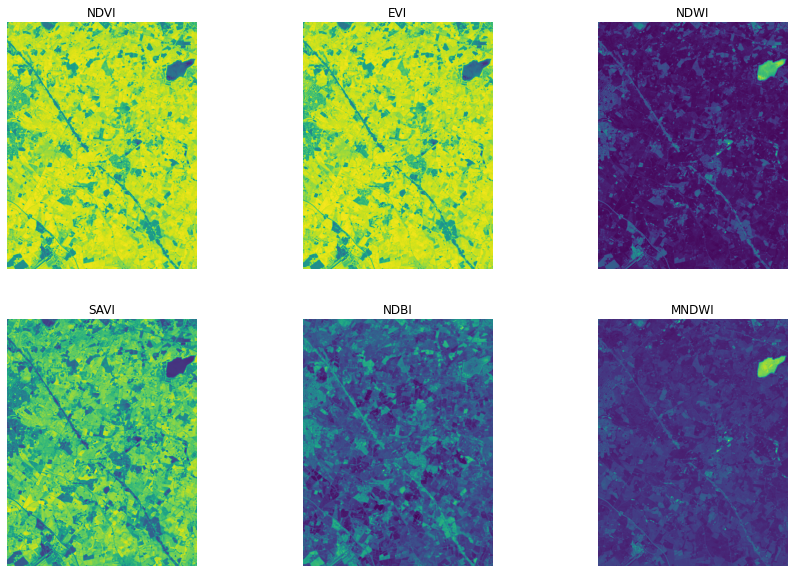

In [44]:
# Open the raster file with spectral indices and plot each of the calculated bands
with rasterio.open(output_path) as src:
    
    # Allow division by zero
    np.seterr(divide='ignore', invalid='ignore')

    # Read the spectral indices
    ndvi = src.read(14)  # NDVI
    evi = src.read(15)   #EVI
    ndwi = src.read(16)  # NDWI
    savi = src.read(17)  # SAVI
    ndbi = src.read(18)  # NDBI
    mndwi = src.read(19) # MNDWI

    # Create a multiplot
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot NDVI
    axes[0, 0].imshow(ndvi, cmap='viridis')
    axes[0, 0].set_title('NDVI')
    axes[0, 0].axis('off')
    
        # Plot EVI
    axes[0, 1].imshow(ndvi, cmap='viridis')
    axes[0, 1].set_title('EVI')
    axes[0, 1].axis('off')

    # Plot NDWI
    axes[0, 2].imshow(ndwi, cmap='viridis')
    axes[0, 2].set_title('NDWI')
    axes[0, 2].axis('off')

    # Plot SAVI
    axes[1, 0].imshow(savi, cmap='viridis')
    axes[1, 0].set_title('SAVI')
    axes[1, 0].axis('off')

    # Plot NDBI
    axes[1, 1].imshow(ndbi, cmap='viridis')
    axes[1, 1].set_title('NDBI')
    axes[1, 1].axis('off')

    # Plot MNDWI
    axes[1, 2].imshow(mndwi, cmap='viridis')
    axes[1, 2].set_title('MNDWI')
    axes[1, 2].axis('off')

    # Display the multiplot
    plt.show()